Punto a


In [1]:
"""
Brute-force: listar todas las posiciones con energía mínima y mostrar
la grilla para cada mínimo, además de una grilla combinada marcando
todas las posiciones minimizadoras.
"""

import math
from itertools import combinations

# Parámetros del potencial de Morse (D0, alpha, r0)
MORSE_PARAMS = {
    ('Fe', 'Fe'): (0.7640, 1.5995, 2.7361),
    ('Fe', 'R'):  (0.6036, 1.6458, 3.1880),
    ('R',  'R'):  (0.3120, 0.9450, 4.0920),
    ('Fe', 'Ti'): (0.8162, 1.4480, 2.9140),
    ('R',  'Ti'): (0.4964, 1.4401, 3.4309),
    ('Ti', 'Ti'): (0.6540, 1.2118, 3.3476),
}

def get_params(a, b):
    key = tuple(sorted((a, b)))
    return MORSE_PARAMS[key]

def morse_potential(r, D0, alpha, r0):
    if r <= 0:
        return 0.0
    return D0 * (math.exp(-2*alpha*(r - r0)) - 2*math.exp(-alpha*(r - r0)))

def total_energy(atom_list, lattice_spacing=1.0):
    E = 0.0
    for (i, (el_i, pos_i)), (j, (el_j, pos_j)) in combinations(enumerate(atom_list), 2):
        dx = (pos_i[0] - pos_j[0]) * lattice_spacing
        dy = (pos_i[1] - pos_j[1]) * lattice_spacing
        r = math.hypot(dx, dy)
        D0, alpha, r0 = get_params(el_i, el_j)
        E += morse_potential(r, D0, alpha, r0)
    return E

def build_4x4_grid_center_R():
    """
    Construye la configuración 4x4 con R en el centro 2x2:
    centro = {(1,1),(2,1),(1,2),(2,2)} -> R
    resto -> Fe
    Devuelve atom_list y lista de índices de los sitios Fe (candidatos).
    """
    atom_list = []
    fe_indices = []
    center_positions = {(1,1), (2,1), (1,2), (2,2)}
    for y in range(4):
        for x in range(4):
            if (x, y) in center_positions:
                atom_list.append(('R', (x, y)))
            else:
                fe_indices.append(len(atom_list))
                atom_list.append(('Fe', (x, y)))
    return atom_list, fe_indices

def make_grid_strings(atom_list):
    """
    Devuelve una matriz 4x4 de strings con 'Fe','R' o 'Ti' según atom_list.
    Nota: origen (0,0) corresponde a x=0,y=0 (abajo-izq).
    """
    grid = [['' for _ in range(4)] for __ in range(4)]
    for el, (x, y) in atom_list:
        grid[y][x] = el
    return grid

def print_grid_from_strings(grid, title=None):
    if title:
        print(title)
    for y in reversed(range(4)):
        row = "  ".join(f"{grid[y][x]:>3}" for x in range(4))
        print(f"y={y}  {row}")
    print("     x=0   x=1   x=2   x=3\n")

def brute_force_all_minima(lattice_spacing=2.8, rel_tol=1e-9, abs_tol=1e-12):
    base_atoms, fe_indices = build_4x4_grid_center_R()

    results = []  # (idx, pos, energy, atoms_with_Ti)
    for idx in fe_indices:
        atoms = [(el, pos) for (el, pos) in base_atoms]
        _, pos = atoms[idx]
        atoms[idx] = ('Ti', pos)
        E = total_energy(atoms, lattice_spacing)
        results.append((idx, pos, E, atoms))

    # encontrar energía mínima
    energies = [r[2] for r in results]
    minE = min(energies)

    # recoger todas las configuraciones con energía ≈ minE
    minima = [r for r in results if math.isclose(r[2], minE, rel_tol=rel_tol, abs_tol=abs_tol)]

    # imprimir todos los resultados resumidos
    print("Resultados fuerza bruta (resumen):")
    for idx, pos, E, _ in results:
        print(f"  Sustitución en {pos} -> E = {E:.6f}")
    print()
    print(f"Energía mínima encontrada: {minE:.6f}")
    print(f"Número de posiciones con energía mínima (tolerancia usada): {len(minima)}")
    print("Posiciones mínimas (coordenadas):", [pos for (_, pos, _, _) in minima])
    print()

    # imprimir la grilla para cada mínimo (cada una con un único Ti)
    for n, (idx, pos, E, atoms) in enumerate(minima, start=1):
        title = f"Grilla mínima #{n} - Ti en {pos}  E = {E:.6f}"
        grid = make_grid_strings(atoms)
        print_grid_from_strings(grid, title=title)

    # imprimir una grilla combinada que marca todas las posiciones minimizadoras con ' M '
    combined_grid = make_grid_strings(base_atoms)  # copia inicial sin Ti
    for (_, pos, _, _) in minima:
        x, y = pos
        # marcar con ' M ' para indicar "sitio minimizador"
        combined_grid[y][x] = ' Ti '
    print_grid_from_strings(combined_grid, title="Grilla combinada")

    return minima, minE

if __name__ == "__main__":
    minima, minE = brute_force_all_minima()

Resultados fuerza bruta (resumen):
  Sustitución en (0, 0) -> E = -9.744382
  Sustitución en (1, 0) -> E = -9.157522
  Sustitución en (2, 0) -> E = -9.157522
  Sustitución en (3, 0) -> E = -9.744382
  Sustitución en (0, 1) -> E = -9.157522
  Sustitución en (3, 1) -> E = -9.157522
  Sustitución en (0, 2) -> E = -9.157522
  Sustitución en (3, 2) -> E = -9.157522
  Sustitución en (0, 3) -> E = -9.744382
  Sustitución en (1, 3) -> E = -9.157522
  Sustitución en (2, 3) -> E = -9.157522
  Sustitución en (3, 3) -> E = -9.744382

Energía mínima encontrada: -9.744382
Número de posiciones con energía mínima (tolerancia usada): 4
Posiciones mínimas (coordenadas): [(0, 0), (3, 0), (0, 3), (3, 3)]

Grilla mínima #1 - Ti en (0, 0)  E = -9.744382
y=3   Fe   Fe   Fe   Fe
y=2   Fe    R    R   Fe
y=1   Fe    R    R   Fe
y=0   Ti   Fe   Fe   Fe
     x=0   x=1   x=2   x=3

Grilla mínima #2 - Ti en (3, 0)  E = -9.744382
y=3   Fe   Fe   Fe   Fe
y=2   Fe    R    R   Fe
y=1   Fe    R    R   Fe
y=0   Fe   Fe  

Punto b

[geom_0.9996] mean_best_E=-9.744382 std=0.000000 mean_accept=0.3101
[geom_0.9992] mean_best_E=-9.744382 std=0.000000 mean_accept=0.2913
[geom_0.998] mean_best_E=-9.744382 std=0.000000 mean_accept=0.1255
[linear] mean_best_E=-9.744382 std=0.000000 mean_accept=0.6188
[recip_1e-4] mean_best_E=-9.744382 std=0.000000 mean_accept=0.5740
[exp_1e-4] mean_best_E=-9.744382 std=0.000000 mean_accept=0.4260


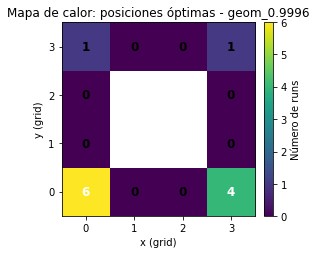

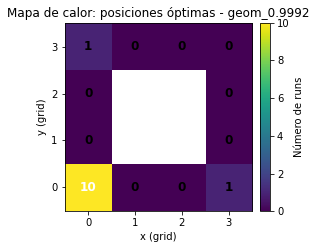

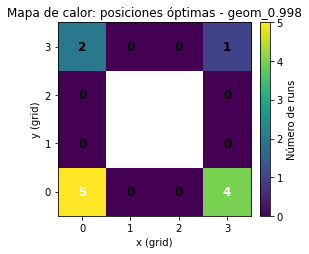

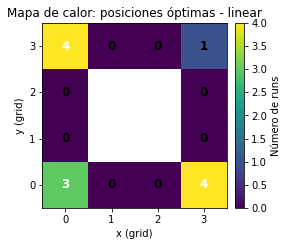

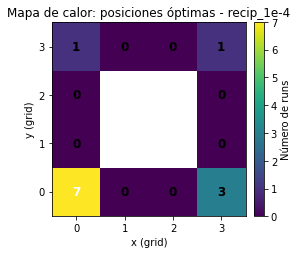

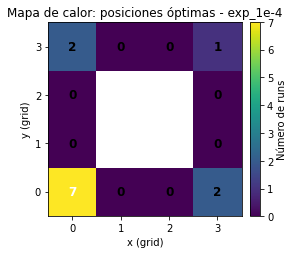

In [9]:
"""
Experimentos con esquemas de enfriamiento (schedules) para Simulated Annealing.
Copia y ejecuta: genera comparativas de rendimiento entre diferentes schedules.
"""

import math, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import statistics

# --------------------------
# Parámetros básicos / Morse
# --------------------------
LATTICE_SPACING = 2.8

MORSE_PARAMS = {
    ('Fe', 'Fe'): {'D0': 0.7640, 'alpha': 1.5995, 'r0': 2.7361},
    ('Fe', 'R'):  {'D0': 0.6036, 'alpha': 1.6458, 'r0': 3.1880},
    ('R',  'R'):  {'D0': 0.3120, 'alpha': 0.9450, 'r0': 4.0920},
    ('Fe', 'Ti'): {'D0': 0.8162, 'alpha': 1.4480, 'r0': 2.9140},
    ('R',  'Ti'): {'D0': 0.4964, 'alpha': 1.4401, 'r0': 3.4309},
    ('Ti', 'Ti'): {'D0': 0.6540, 'alpha': 1.2118, 'r0': 3.3476},
}

def get_morse_params_any_order(a,b):
    if (a,b) in MORSE_PARAMS: return MORSE_PARAMS[(a,b)]
    if (b,a) in MORSE_PARAMS: return MORSE_PARAMS[(b,a)]
    raise KeyError((a,b))

def morse_potential(r,D0,alpha,r0):
    x = math.exp(-alpha*(r-r0))
    return D0*(x*x - 2.0*x)

# --------------------------
# Construcción grilla y dist
# --------------------------
def build_lattice():
    atom_types = []
    coords = []
    corners = {(1,1),(1,2),(2,1),(2,2)}
    for y in range(4):
        for x in range(4):
            coords.append((x*LATTICE_SPACING, y*LATTICE_SPACING))
            atom_types.append("R" if (x,y) in corners else "Fe")
    fe_indices = [i for i,t in enumerate(atom_types) if t == "Fe"]
    return atom_types, coords, fe_indices

def build_distance_matrix(coords):
    n = len(coords)
    D = np.zeros((n,n))
    for i in range(n):
        xi, yi = coords[i]
        for j in range(i+1,n):
            xj, yj = coords[j]
            r = math.hypot(xi-xj, yi-yj)
            D[i,j] = r; D[j,i] = r
    return D

# --------------------------
# Energía local y total
# --------------------------
def local_site_energy(idx, types, dist_matrix):
    E = 0.0
    n = len(types)
    for j in range(n):
        if j == idx: continue
        p = get_morse_params_any_order(types[idx], types[j])
        E += morse_potential(dist_matrix[idx,j], p['D0'], p['alpha'], p['r0'])
    return E

def total_energy(types, dist_matrix):
    E = 0.0
    n = len(types)
    for i in range(n):
        for j in range(i+1,n):
            p = get_morse_params_any_order(types[i], types[j])
            E += morse_potential(dist_matrix[i,j], p['D0'], p['alpha'], p['r0'])
    return E

# --------------------------
# Simulated Annealing flexible: recibe schedule(k) -> T
# --------------------------
def simulated_annealing_with_schedule(atom_types_base, fe_indices, dist_matrix,
                                      schedule_fn,
                                      n_iterations=30000,
                                      seed=None):
    """
    schedule_fn: función que recibe (step, n_iterations, T0, **kwargs) y devuelve T
    """
    if seed is not None:
        np.random.seed(seed); random.seed(seed)

    n = len(atom_types_base)
    current_idx = random.choice(fe_indices)
    types = atom_types_base.copy()
    types[current_idx] = "Ti"

    E_current = total_energy(types, dist_matrix)
    best_E = E_current; best_idx = current_idx

    history = [E_current]; trajectory = [current_idx]
    accepted = 0; attempts = 0

    T0 = 1.0  # base temp passed to schedule if needed

    for step in range(n_iterations):
        T = schedule_fn(step, n_iterations, T0)  # temperature at this step
        if T <= 0:
            # if schedule returns nonpositive, treat as T ~ 0 and finish early
            break

        proposal_idx = random.choice(fe_indices)
        if proposal_idx == current_idx:
            history.append(E_current); trajectory.append(current_idx)
            continue
        attempts += 1

        Ei_before = local_site_energy(current_idx, types, dist_matrix)
        Ej_before = local_site_energy(proposal_idx, types, dist_matrix)

        types_prop = types.copy()
        types_prop[current_idx] = "Fe"
        types_prop[proposal_idx] = "Ti"

        Ei_after = local_site_energy(current_idx, types_prop, dist_matrix)
        Ej_after = local_site_energy(proposal_idx, types_prop, dist_matrix)

        delta = (Ei_after + Ej_after) - (Ei_before + Ej_before)
        accept_prob = math.exp(-delta/T) if delta > 0 else 1.0

        if random.random() < accept_prob:
            types = types_prop
            current_idx = proposal_idx
            E_current += delta
            accepted += 1
            if E_current < best_E:
                best_E = E_current; best_idx = current_idx

        history.append(E_current); trajectory.append(current_idx)

    acceptance_rate = accepted / attempts if attempts>0 else 0.0
    return {
        'best_idx': best_idx, 'best_E': best_E,
        'E_current': E_current,
        'history': history, 'trajectory': trajectory,
        'accepted': accepted, 'attempts': attempts,
        'acceptance_rate': acceptance_rate
    }

# --------------------------
# DEFINICIONES DE SCHEDULES (funciones)
# --------------------------
def schedule_geometric_factory(cooling_rate):
    # T_{k+1} = T_k * cooling_rate  -> implementamos T(k) = T0 * cooling_rate^k
    def sched(k, n, T0):
        return T0 * (cooling_rate ** k)
    return sched

def schedule_linear_factory():
    # T(k) = T0 * max(0, 1 - k/(n-1))
    def sched(k, n, T0):
        return T0 * max(0.0, 1.0 - k / max(1, (n-1)))
    return sched

def schedule_reciprocal_factory(alpha):
    # T(k) = T0 / (1 + alpha * k)
    def sched(k, n, T0):
        return T0 / (1.0 + alpha * k)
    return sched

def schedule_exponential_factory(lmbda):
    # T(k) = T0 * exp(-lambda * k)
    def sched(k, n, T0):
        return T0 * math.exp(-lmbda * k)
    return sched

# --------------------------
# Ejecutar experimento: varios schedules y múltiples runs
# --------------------------
def run_experiment_all(schedules, n_runs=10, n_iterations=30000, seed0=1000):
    """
    schedules: dict name -> schedule_fn
    Ejecuta n_runs corridas independientes por cada schedule.
    Retorna resultados agregados.
    """
    atom_types_base, coords, fe_indices = build_lattice()
    dist_matrix = build_distance_matrix(coords)

    results = {}
    for name, sched_fn in schedules.items():
        runs = []
        for r in range(n_runs):
            seed = seed0 + r  # reproducible pero variado
            out = simulated_annealing_with_schedule(atom_types_base, fe_indices, dist_matrix,
                                                    schedule_fn=sched_fn,
                                                    n_iterations=n_iterations,
                                                    seed=seed)
            runs.append(out)
        # calcular estadísticas
        best_Es = [o['best_E'] for o in runs]
        mean_best = statistics.mean(best_Es)
        std_best = statistics.pstdev(best_Es) if len(best_Es)>1 else 0.0
        mean_accept = statistics.mean([o['acceptance_rate'] for o in runs])
        results[name] = {
            'runs': runs,
            'mean_best_E': mean_best,
            'std_best_E': std_best,
            'mean_accept': mean_accept
        }
        print(f"[{name}] mean_best_E={mean_best:.6f} std={std_best:.6f} mean_accept={mean_accept:.4f}")
    # also return coords and fe_indices for plotting
    return results, coords, fe_indices

# --------------------------
# Graficado de comparativas
# --------------------------
def plot_summary(results, n_runs_show=5):
    names = list(results.keys())
    means = [results[n]['mean_best_E'] for n in names]
    stds  = [results[n]['std_best_E']  for n in names]
    accs  = [results[n]['mean_accept'] for n in names]

    x = np.arange(len(names))
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names, rotation=30)
    plt.ylabel("Mean best_E (± std)")
    plt.title("Comparativa: Mejores energías")
    plt.subplot(1,2,2)
    plt.bar(x, accs)
    plt.xticks(x, names, rotation=30)
    plt.ylabel("Acceptance rate (mean)")
    plt.title("Tasa de aceptación media")
    plt.tight_layout()
    plt.show()

def plot_avg_history(results, schedules_to_plot=None):
    # Calcula history promedio (alineado) por schedule
    if schedules_to_plot is None:
        schedules_to_plot = list(results.keys())
    plt.figure(figsize=(8,5))
    for name in schedules_to_plot:
        runs = results[name]['runs']
        # pad/truncate histories to the same length (min length)
        minlen = min(len(o['history']) for o in runs)
        arr = np.array([o['history'][:minlen] for o in runs])
        mean_hist = arr.mean(axis=0)
        plt.plot(mean_hist, label=f"{name} (mean)")
    plt.xlabel("Iteración")
    plt.ylabel("Energía (media)")
    plt.legend()
    plt.title("Historia promedio de energía por schedule")
    plt.grid(True)
    plt.show()

# --------------------------
# EJEMPLO DE USO
# --------------------------
if __name__ == "__main__":
        # --------------------------
    # Definir schedules a comparar (incluye la configuración que ya funcionó)
    # --------------------------
    schedules = {
        # La configuración que nos funcionó — geometric cooling, cooling_rate 0.9996
        "geom_0.9996": schedule_geometric_factory(0.9996),

        
        "geom_0.9992": schedule_geometric_factory(0.9992),
        "geom_0.998":  schedule_geometric_factory(0.998),
        "linear":      schedule_linear_factory(),
        "recip_1e-4":  schedule_reciprocal_factory(1e-4),
        "exp_1e-4":    schedule_exponential_factory(1e-4),
    }

    # parámetros del experimento
    n_runs = 12            # corridas independientes por cada schedule
    n_iterations = 40000   # <-- fijado a 40k para incluir la configuración "que funcionó"
    seed0 = 5000

    # Ejecutar experimento
    results, coords, fe_indices = run_experiment_all(schedules, n_runs=n_runs, n_iterations=n_iterations, seed0=seed0)

    atom_types_base, coords, fe_indices = build_lattice()

    for name, data in results.items():
        best_positions = [run['best_idx'] for run in data['runs']]
        counts = Counter(best_positions)

        # Construir matriz 4x4 con conteos; NaN en celdas R para que queden en blanco
        heat = np.full((4,4), np.nan)
        for idx, (x, y) in enumerate(coords):
            gx = int(round(x / LATTICE_SPACING))
            gy = int(round(y / LATTICE_SPACING))
            if atom_types_base[idx] == 'Fe':
                heat[gy, gx] = counts.get(idx, 0)
            else:
                heat[gy, gx] = np.nan

        masked = np.ma.masked_invalid(heat)
        plt.figure(figsize=(4,4))
        im = plt.imshow(masked, origin='lower', cmap='viridis')
        plt.colorbar(im, fraction=0.046, pad=0.04, label='Número de runs')
        plt.title(f"Mapa de calor: posiciones óptimas - {name}")
        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.xlabel('x (grid)')
        plt.ylabel('y (grid)')

        # Anotar conteos en cada celda Fe
        vmax = np.nanmax(heat) if not np.isnan(np.nanmax(heat)) else 1
        for gx in range(4):
            for gy in range(4):
                val = heat[gy, gx]
                if not np.isnan(val):
                    # color del texto según contraste
                    txt_color = 'white' if val > (0.5 * vmax) else 'black'
                    plt.text(gx, gy, str(int(val)), ha='center', va='center', color=txt_color, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

